Attorney to client location

Attorney time when questions have high volume, Right volunteer at the right time

In [ ]:
!pip install plotly-geo
!pip install geopandas
!pip install pyshp
!pip install shapely
!pip install us
!pip install pymannkendall
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import math
from urllib.request import urlopen
import seaborn as sns
import json
import plotly.express as px
from datetime import datetime, timedelta
import pymannkendall as mk
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf

In [ ]:
# base code
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type

style_talk = 'seaborn-talk'    #refer to plt.style.available

class LinearRegDiagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Authors:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.

        Matt Spinelli (m3spinelli@gmail.com, where 3 = r)
        (1) Fixed incorrect annotation of the top most extreme residuals in
            the Residuals vs Fitted and, especially, the Normal Q-Q plots.
        (2) Changed Residuals vs Leverage plot to match closer the y-axis
            range shown in the equivalent plot in the R package ggfortify.
        (3) Added horizontal line at y=0 in Residuals vs Leverage plot to
            match the plots in R package ggfortify and base R.
        (4) Added option for placing a vertical guideline on the Residuals
            vs Leverage plot using the rule of thumb of h = 2p/n to denote
            high leverage (high_leverage_threshold=True).
        (5) Added two more ways to compute the Cook's Distance (D) threshold:
            * 'baseR': D > 1 and D > 0.5 (default)
            * 'convention': D > 4/n
            * 'dof': D > 4 / (n - k - 1)
        (6) Fixed class name to conform to Pascal casing convention
        (7) Fixed Residuals vs Leverage legend to work with loc='best'
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)
        self.nresids = len(self.residual_norm)

    def __call__(self, plot_context='seaborn-paper', **kwargs):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(
                ax=ax[1,1],
                high_leverage_threshold = kwargs.get('high_leverage_threshold'),
                cooks_threshold = kwargs.get('cooks_threshold'))
            plt.show()

        return self.vif_table(), fig, ax,

    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.argsort(residual_abs), 0)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        fig = QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for i, x, y in self.__qq_top_resid(QQ.theoretical_quantiles, abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(x, y),
                ha='right',
                color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')

        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None, high_leverage_threshold=False, cooks_threshold='baseR'):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        factors = []
        if cooks_threshold == 'baseR' or cooks_threshold is None:
            factors = [1, 0.5]
        elif cooks_threshold == 'convention':
            factors = [4/self.nresids]
        elif cooks_threshold == 'dof':
            factors = [4/ (self.nresids - self.nparams)]
        else:
            raise ValueError("threshold_method must be one of the following: 'convention', 'dof', or 'baseR' (default)")
        for i, factor in enumerate(factors):
            label = "Cook's distance" if i == 0 else None
            xtemp, ytemp = self.__cooks_dist_line(factor)
            ax.plot(xtemp, ytemp, label=label, lw=1.25, ls='--', color='red')
            ax.plot(xtemp, np.negative(ytemp), lw=1.25, ls='--', color='red')

        if high_leverage_threshold:
            high_leverage = 2 * self.nparams / self.nresids
            if max(self.leverage) > high_leverage:
                ax.axvline(high_leverage, label='High leverage', ls='-.', color='purple', lw=1)

        ax.axhline(0, ls='dotted', color='black', lw=1.25)
        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_ylim(min(self.residual_norm)-0.1, max(self.residual_norm)+0.1)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        plt.legend(loc='best')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        return (vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y


    def __qq_top_resid(self, quantiles, top_residual_indices):
        """
        Helper generator function yielding the index and coordinates
        """
        offset = 0
        quant_index = 0
        previous_is_negative = None
        for resid_index in top_residual_indices:
            y = self.residual_norm[resid_index]
            is_negative = y < 0
            if previous_is_negative == None or previous_is_negative == is_negative:
                offset += 1
            else:
                quant_index -= offset
            x = quantiles[quant_index] if is_negative else np.flip(quantiles, 0)[quant_index]
            quant_index += 1
            previous_is_negative = is_negative
            yield resid_index, x, y


In [ ]:
attorneys = pd.read_csv('/content/drive/MyDrive/Data to share/data/attorneys.csv')  
#attorneys = pd.read_csv('/content/drive/MyDrive/ASA/data/attorneys.csv')  
categories = pd.read_csv('/content/drive/MyDrive/Data to share/data/categories.csv')  
clients = pd.read_csv('/content/drive/MyDrive/Data to share/data/clients.csv')  
#questionposts = pd.read_csv('/content/drive/MyDrive/Data to share/data/questionposts.csv')  
questions = pd.read_csv('/content/drive/MyDrive/Data to share/data/questions.csv')  
statesites = pd.read_csv('/content/drive/MyDrive/Data to share/data/statesites.csv') 
subcategories = pd.read_csv('/content/drive/MyDrive/Data to share/data/subcategories.csv') 
fips2 = pd.read_csv('/content/drive/MyDrive/fips2county.tsv', sep='\t', header=0) 

In [ ]:
att_plot = attorneys.drop(columns=['Id', 'CreatedUtc', 'AttorneyUno'])
att_counts = att_plot.groupby(by=['StateAbbr']).size()
att_counts = att_counts.reset_index()
att_counts = att_counts.rename(columns={0: "Count"})
att_counts

,StateAbbr,Count
0,AK,110
1,AL,138
2,AR,192
3,AZ,104
4,CA,245
5,CT,103
6,FL,1103
7,GA,308
8,HI,125
9,IA,67


In [ ]:
att_fips = att_counts.merge(fips2, how='inner', left_on=['StateAbbr'], right_on=["StateAbbr"])
att_fips = att_fips[['StateAbbr','Count','StateFIPS']]
att_fips.drop_duplicates(inplace=True)
att_fips

,StateAbbr,Count,StateFIPS
0,AK,110,2
30,AL,138,1
97,AR,192,5
172,AZ,104,4
187,CA,245,6
245,CT,103,9
253,FL,1103,12
320,GA,308,13
479,HI,125,15
484,IA,67,19


In [ ]:
client_plot = clients[['StateAbbr','County','StateName','PostalCode']]
client_counts = client_plot.groupby(by=['StateAbbr']).size()
client_counts = client_counts.reset_index()
client_counts = client_counts.rename(columns={0: "Count"})
client_counts

,StateAbbr,Count
0,AK,1567
1,AL,1538
2,AR,4243
3,AZ,9580
4,CA,5188
5,CT,2206
6,FL,30525
7,GA,13986
8,HI,4222
9,IA,3099


In [ ]:
client_fips = client_counts.merge(fips2, how='inner', left_on=['StateAbbr'], right_on=["StateAbbr"])
client_fips = client_fips[['StateAbbr','Count','StateFIPS']]
client_fips.drop_duplicates(inplace=True)
client_fips

,StateAbbr,Count,StateFIPS
0,AK,1567,2
30,AL,1538,1
97,AR,4243,5
172,AZ,9580,4
187,CA,5188,6
245,CT,2206,9
253,FL,30525,12
320,GA,13986,13
479,HI,4222,15
484,IA,3099,19


In [ ]:
perc_plot = client_fips.merge(
    att_fips, 
    how='inner', 
    left_on=['StateFIPS'], 
    right_on=['StateFIPS'])
perc_plot.loc[:,'Percent'] = (perc_plot['Count_y']/perc_plot['Count_x'])*100
perc_df = perc_plot[['StateAbbr_x','StateFIPS', 'Percent']]
perc_df.loc[:,'StateFIPS'] = perc_df['StateFIPS'].dropna().astype(int).round().astype(str)
perc_df

<ipython-input-205-a79d65e2db95>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,StateAbbr_x,StateFIPS,Percent
0,AK,2,7.019783
1,AL,1,8.972692
2,AR,5,4.525100
3,AZ,4,1.085595
4,CA,6,4.722436
5,CT,9,4.669084
6,FL,12,3.613432
7,GA,13,2.202202
8,HI,15,2.960682
9,IA,19,2.161988


In [ ]:
perc_df = perc_df[perc_df.StateAbbr_x != 'ID']

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Choropleth(
    locations=perc_df['StateAbbr_x'], # Spatial coordinates
    z = perc_df['Percent'], # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Ratio of Attorney to Client",
))

fig.update_layout(
    title_text = 'Ratio of Attorney to Client by US States',
    geo_scope='usa', # limite map scope to USA
)

fig.show()


In [ ]:
questions['AskedOnUtc'] =  pd.to_datetime(questions['AskedOnUtc'])
questions_count = questions.groupby(by=[questions['AskedOnUtc'].dt.date, 'StateAbbr']).size()
questions_count = questions_count.reset_index()
questions_count = questions_count.rename(columns={0: "Count"})
questions_count
px.choropleth(questions_count, 
              locations = 'StateAbbr',
              color="Count", 
              animation_frame="AskedOnUtc",
              color_continuous_scale="Reds",
              locationmode='USA-states',
              scope="usa",
              range_color=(0, 20),
              title = 'Number of questions per day by US States',
)

In [ ]:
tz = pd.read_csv('/content/drive/MyDrive/timezone_us.csv', header=None, names=['StateAbbr','TZ'])
tz['TZ'].replace({'CST': 'US/Central'}, inplace=True)
tz['TZ'].replace({'PST': 'US/Pacific'}, inplace=True)
tz['TZ'].replace({'EST': 'US/Eastern'}, inplace=True)
tz['TZ'].replace({'MST': 'US/Mountain'}, inplace=True)
tz['TZ'].replace({'AKST': 'US/Alaska'}, inplace=True)
tz['TZ'].replace({'AST': 'Atlantic'}, inplace=True)
questions_plots = questions[['StateAbbr','AskedOnUtc']]
questions_plots = questions_plots.merge(
    tz, 
    how='left', 
    left_on=['StateAbbr'], 
    right_on=['StateAbbr'])
questions_plots['AskedOnUtc'] =  pd.to_datetime(questions_plots['AskedOnUtc'])
questions_plots = questions_plots[questions_plots['TZ'].notnull()]
questions_plots.loc[:,'Local'] = questions_plots.apply(lambda x: x['AskedOnUtc'].tz_localize('UTC').tz_convert(x['TZ']), axis=1)
questions_plots.loc[:,'Hour'] = questions_plots.apply(lambda x: x['AskedOnUtc'].tz_localize('UTC').tz_convert(x['TZ']).hour, axis=1)
questions_plots.loc[:,'Year'] = questions_plots.apply(lambda x: x['AskedOnUtc'].tz_localize('UTC').tz_convert(x['TZ']).year, axis=1)
questions_plots.loc[:,'Month'] = questions_plots.apply(lambda x: x['AskedOnUtc'].tz_localize('UTC').tz_convert(x['TZ']).month, axis=1)
questions_plots.loc[:,'Day'] = questions_plots.apply(lambda x: x['AskedOnUtc'].tz_localize('UTC').tz_convert(x['TZ']).day, axis=1)

In [ ]:
questions_plots = questions_plots.loc[questions_plots.Year >=2018]
questions_plots = questions_plots.groupby(by=['TZ','Year','Hour','Month','Day']).size()
questions_plots = questions_plots.reset_index()
questions_plots = questions_plots.rename(columns={0: "Count"})
questions_plots

,TZ,Year,Hour,Month,Day,Count
0,HST,2018,0,5,13,1
1,HST,2018,0,7,1,1
2,HST,2018,0,7,18,1
3,HST,2018,0,9,4,1
4,HST,2018,0,9,5,1
...,...,...,...,...,...,...
61531,US/Pacific,2022,23,1,3,1
61532,US/Pacific,2022,23,1,16,1
61533,US/Pacific,2022,23,1,18,1
61534,US/Pacific,2022,23,1,23,2


In [ ]:
temp = questions_plots.loc[questions_plots.TZ == 'US/Eastern']
temp['date'] = pd.to_datetime(temp[['Year', 'Month', 'Day', 'Hour']])
temp.set_index('date',inplace=True)
temp.drop(columns=['Year', "Month", "Day"],inplace=True)
temp = temp.asfreq('H')
temp.Count.fillna(0, inplace=True)

<ipython-input-226-0e4bbd681986>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-226-0e4bbd681986>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
tz['TZ'].unique()

array(['US/Central', 'US/Alaska', 'US/Mountain', 'US/Pacific',
       'US/Eastern', 'HST', 'Atlantic'], dtype=object)

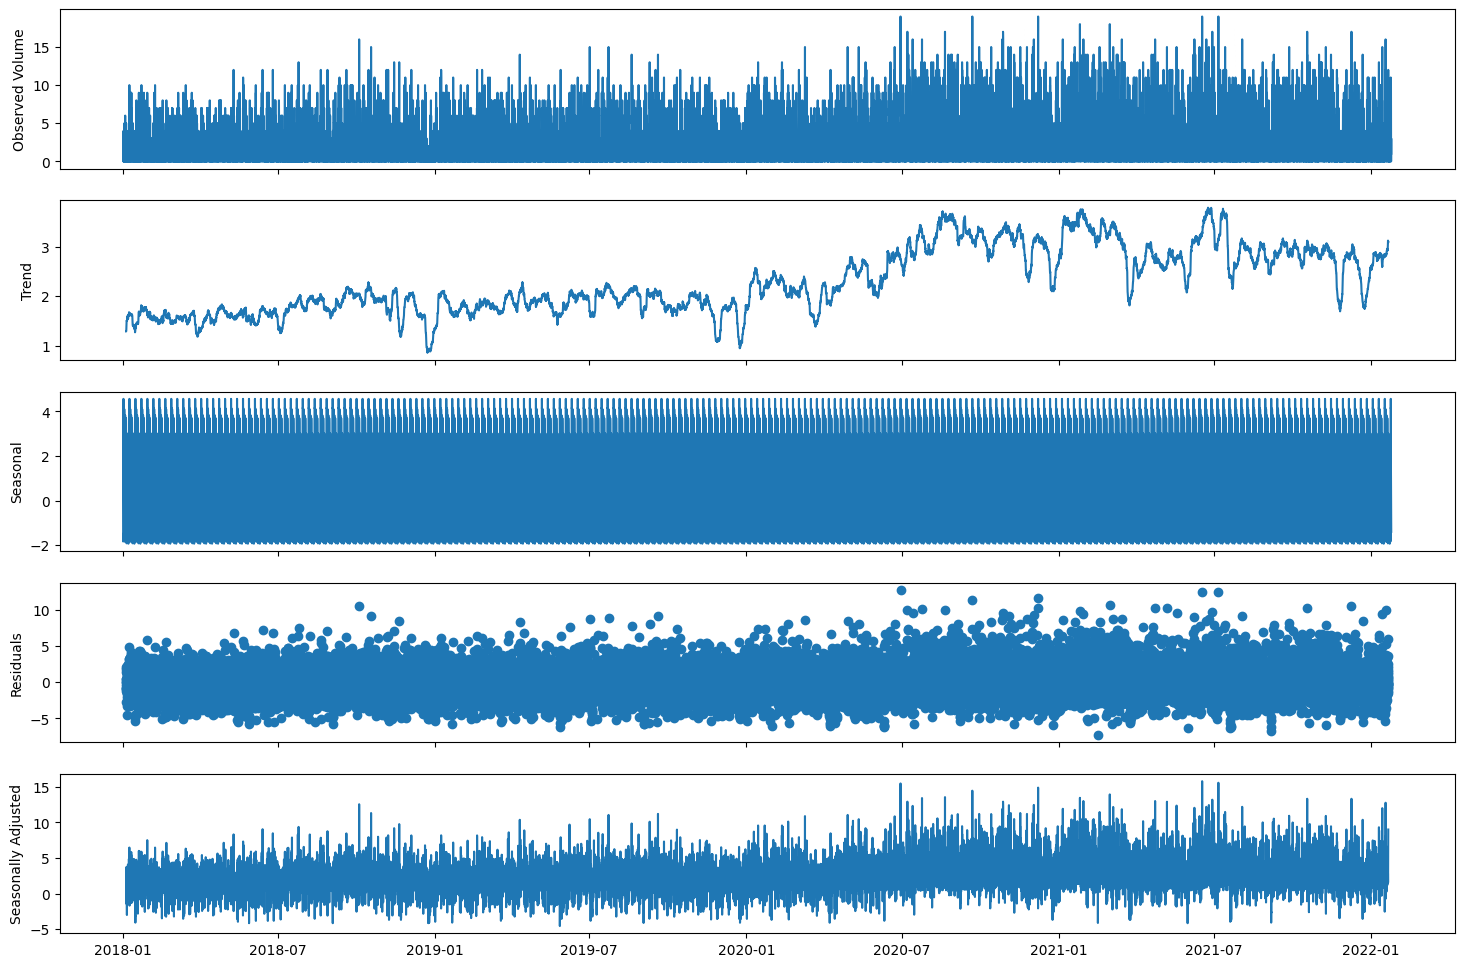

In [ ]:
result = seasonal_decompose(temp['Count'], model='additive',period=168)
fig, axs = plt.subplots(5, 1, figsize=(18, 12), sharex=True)
axs[0].plot(temp.index, result.observed)
axs[0].set_ylabel("Observed Volume")
axs[1].plot(temp.index, result.trend)
axs[1].set_ylabel("Trend")

axs[2].plot(temp.index, result.seasonal)
axs[2].set_ylabel("Seasonal")

axs[3].scatter(temp.index, result.resid)
axs[3].set_ylabel("Residuals")

axs[4].plot(temp.index, result.trend + result.resid)
axs[4].set_ylabel("Seasonally Adjusted")
plt.show()

Text(0.5, 1.0, 'Eastern Time Trend for Questions Asked')

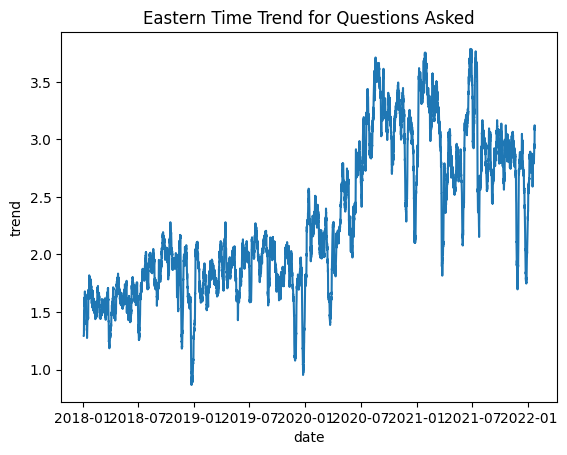

In [ ]:
sns.lineplot(x=temp.index, y=result.trend).set_title('Eastern Time Trend for Questions Asked')

In [ ]:
# extract trend for each area
trends= {}

for x in tz['TZ'].unique():
  temp = questions_plots.loc[questions_plots.TZ == x]
  temp['date'] = pd.to_datetime(temp[['Year', 'Month', 'Day', 'Hour']])
  temp.set_index('date',inplace=True)
  temp.drop(columns=['Year', "Month", "Day"],inplace=True)
  temp = temp.asfreq('H')
  temp.Count.fillna(0, inplace=True)
  if len(temp) <= 336: 
        continue
  # period = 168: hours in a week to capture both hours of a day and days of a week seasonality
  result = seasonal_decompose(temp['Count'], model='additive',period=168)
  plt.plot(temp.index, result.trend)
  plt.show()

  trends[x] = result.trend

In [ ]:
questions_plots['date'] = pd.to_datetime(questions_plots[['Year', 'Month', 'Day', 'Hour']])
questions_plots

,TZ,Year,Hour,Month,Day,Count,date
0,HST,2018,0,5,13,1,2018-05-13 00:00:00
1,HST,2018,0,7,1,1,2018-07-01 00:00:00
2,HST,2018,0,7,18,1,2018-07-18 00:00:00
3,HST,2018,0,9,4,1,2018-09-04 00:00:00
4,HST,2018,0,9,5,1,2018-09-05 00:00:00
...,...,...,...,...,...,...,...
61531,US/Pacific,2022,23,1,3,1,2022-01-03 23:00:00
61532,US/Pacific,2022,23,1,16,1,2022-01-16 23:00:00
61533,US/Pacific,2022,23,1,18,1,2022-01-18 23:00:00
61534,US/Pacific,2022,23,1,23,2,2022-01-23 23:00:00


In [ ]:
temp_df = trends['US/Pacific'].reset_index()
temp_df['TZ'] = 'US/Pacific'
temp_df

,date,trend,TZ
0,2020-09-01 14:00:00,NaN,US/Pacific
1,2020-09-01 15:00:00,NaN,US/Pacific
2,2020-09-01 16:00:00,NaN,US/Pacific
3,2020-09-01 17:00:00,NaN,US/Pacific
4,2020-09-01 18:00:00,NaN,US/Pacific
...,...,...,...
12245,2022-01-24 19:00:00,NaN,US/Pacific
12246,2022-01-24 20:00:00,NaN,US/Pacific
12247,2022-01-24 21:00:00,NaN,US/Pacific
12248,2022-01-24 22:00:00,NaN,US/Pacific


In [ ]:
questions_plots = questions[['AskedOnUtc','ClosedByAttorneyUno']].copy()
questions_plots.loc[:,'AskedOnUtc'] =  pd.to_datetime(questions_plots['AskedOnUtc'])
def calc_new_col(row):
  if pd.isnull(row['ClosedByAttorneyUno']):
    return 0
  else:
    return 1

questions_plots["Closed_by_attorney"] = questions_plots.apply(calc_new_col, axis=1)
closed_by_att = questions_plots.groupby([questions_plots['AskedOnUtc'].dt.date]).apply(lambda x: x['Closed_by_attorney'].sum()/len(x))
closed_by_att = closed_by_att.reset_index()
closed_by_att.loc[:,'AskedOnUtc'] =  pd.to_datetime(closed_by_att['AskedOnUtc'])

<ipython-input-163-22e9bcd6873b>:2: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

<ipython-input-163-22e9bcd6873b>:12: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



In [ ]:
closed_by_att

,AskedOnUtc,0
0,2012-10-04,0.000000
1,2012-10-08,0.000000
2,2012-11-21,1.000000
3,2012-11-26,1.000000
4,2012-11-28,1.000000
...,...,...
3296,2022-01-21,0.123077
3297,2022-01-22,0.116883
3298,2022-01-23,0.074074
3299,2022-01-24,0.098361


<Axes: xlabel='AskedOnUtc', ylabel='0'>

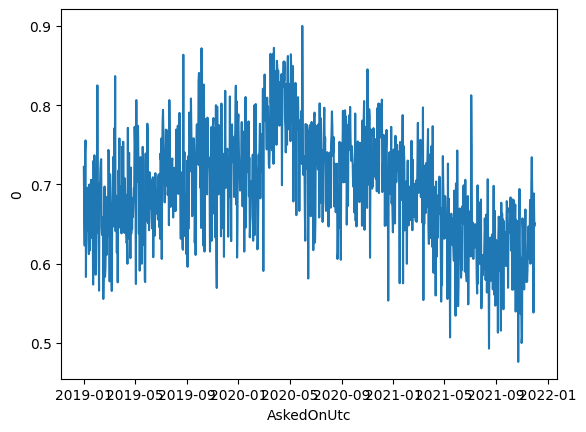

In [ ]:
sns.lineplot(x='AskedOnUtc', y=0,data=closed_by_att.loc[(closed_by_att.AskedOnUtc.dt.year >= 2019) & (closed_by_att.AskedOnUtc <= datetime(2021, 12, 1))])

In [ ]:
closed_by_att

,AskedOnUtc,0
0,2012-10-04,0.000000
1,2012-10-08,0.000000
2,2012-11-21,1.000000
3,2012-11-26,1.000000
4,2012-11-28,1.000000
...,...,...
3296,2022-01-21,0.123077
3297,2022-01-22,0.116883
3298,2022-01-23,0.074074
3299,2022-01-24,0.098361


In [ ]:
questions_plots = questions[['AskedOnUtc','ClosedByAttorneyUno']].copy()
questions_plots.loc[:,'AskedOnUtc'] =  pd.to_datetime(questions_plots['AskedOnUtc'])
def calc_new_col(row):
  if pd.isnull(row['ClosedByAttorneyUno']):
    return 0
  else:
    return 1

questions_plots["Closed_by_attorney"] = questions_plots.apply(calc_new_col, axis=1)
closed_by_att = questions_plots.groupby([questions_plots['AskedOnUtc'].dt.date]).apply(lambda x: x['Closed_by_attorney'].sum()/len(x))
closed_by_att = closed_by_att.reset_index()
closed_by_att.loc[:,'AskedOnUtc'] =  pd.to_datetime(closed_by_att['AskedOnUtc'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
